#Clustering application for duplicates detection
# **AUTHOR:**
Nguyễn Phạm Thanh Phong: 21522458
<br>
Ngày cập nhật: 18:30 10/6/2024
<br>
Reference resources:

*   [DBScan algorithm](https://www.youtube.com/watch?v=RDZUdRSDOok)
*   [Cosine similarity](https://www.youtube.com/watch?v=e9U0QAFbfLI)
*   [Documentation for **Fine tuning**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

## Import neccessary libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

## Import and mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls "drive/MyDrive/my_shared_shortcut/MODELS-logs"

MotocycleDataset-DEMO-cluster-duplicates-1000.csv  predictions-split-3.csv  TP-models.zip
predictions-split-1.csv				   predictions-split-4.csv
predictions-split-2.csv				   predictions-split-5.csv


In [10]:
!ls "drive/MyDrive/my_shared_shortcut/Public"

CS114.Clustering.ipynb		      MotocycleDataset-Splits-1-Train.csv
CS114.Evaluation.ipynb		      MotocycleDataset-Splits-2-Test.csv
CS114.O21-O21.KHCL.BaoCaoDACK.ipynb   MotocycleDataset-Splits-2-Train.csv
CS114.O21-O21.KHCL.ScoreBoard.csv     MotocycleDataset-Splits-3-Test.csv
CS114.O21-O21.KHCL.ScoreBoard.gsheet  MotocycleDataset-Splits-3-Train.csv
CS114.Tool.CreateSplit.ipynb	      MotocycleDataset-Splits-4-Test.csv
CS114.Tool.DatasetStat.ipynb	      MotocycleDataset-Splits-4-Train.csv
CS114.Tool.DatasetViz.ipynb	      MotocycleDataset-Splits-5-Test.csv
CS114.Train.ipynb		      MotocycleDataset-Splits-5-Train.csv
Honda				      MotocycleDataset-Splits-5-Train.gsheet
MotocycleDataset-1.csv		      Others
MotocycleDataset-1.gsheet	      Suzuki
MotocycleDataset-2.csv		      VinFast
MotocycleDataset-Splits-1-Test.csv    Yamaha


### Read csv file of loadable images with full_path (according to my local directory on my device)
### Then transform the full path to the full-path to Mr.Duy's Public Drive

In [7]:
df = pd.read_csv("drive/MyDrive/my_shared_shortcut/MODELS-logs/MotocycleDataset-DEMO-cluster-duplicates-1000.csv")

In [11]:
df['full_path'] = df['full_path'].str.replace('./CLASS-IMAGES', './drive/MyDrive/my_shared_shortcut/Public')

## Explain the whole idea of this clustering:
The compute histogram display image into gray scale, which mean values range
from 0 to 255
Then flattern -> compress it to 1D array
Exaple:
<br>
[ 1 , 2 ... ]
  <br>
[ 150 , 160, ... ]
  <br>
=> [1 2 ,..., 150, 160, ...]
<br>
```
similarity_matrix = cosine_similarity(features_array)
```
This block of code calculate the cosine of image vector after being flatten into
1D array
<br>
Each element in features
```
features = []
```
will now be an array, represent for vector
<br>
The computation from
DBSCAN uses the cosine distance metric
1
−
sim
(
𝐻
1
,
𝐻
2
)
, where a higher cosine similarity implies a smaller distance.
<br>

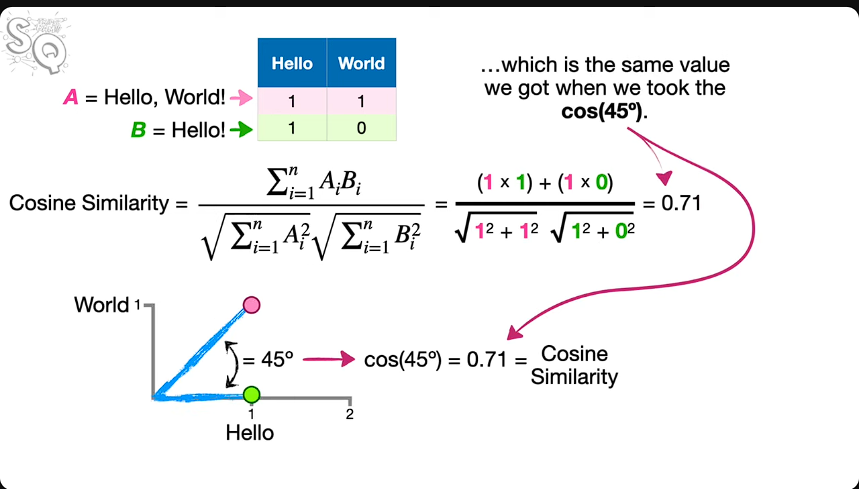

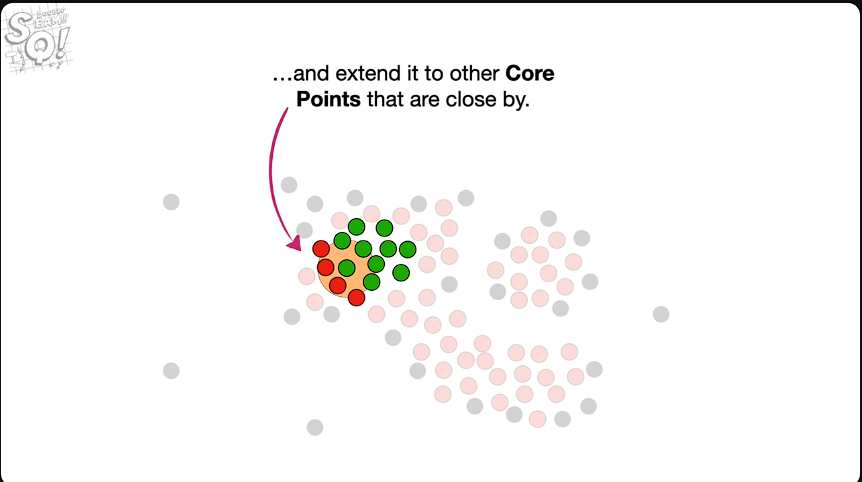

## Implementation of DBScan
Choosing eps=0.02 to adjust the threshold
<br>
The Acceptable value to be considered in same cluster
<br>
The lower the value of **"eps"**. The increase in numbers of clusters

In [17]:
def compute_histogram(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    return hist.flatten()


# Extract features from all images
features = []
for path in df["full_path"]:
    hist = compute_histogram(path)
    features.append(hist)

# Convert list to NumPy array for clustering
features_array = np.array(features)

# Compute similarities (cosine similarity)
similarity_matrix = cosine_similarity(features_array)

# Cluster images using DBSCAN
db = DBSCAN(eps=0.02, min_samples=2, metric="cosine").fit(features_array)
labels = db.labels_

# Create a DataFrame to store results
df["cluster_label"] = labels

# Identify duplicates
duplicates = df[df["cluster_label"] != -1]

# Display results
print("Clusters and Duplicates:")
duplicates

Clusters and Duplicates:


,full_path,label_idx,cluster_label
0,./drive/MyDrive/my_shared_shortcut/Public/Yama...,3,0
4,./drive/MyDrive/my_shared_shortcut/Public/Suzu...,2,1
6,./drive/MyDrive/my_shared_shortcut/Public/Suzu...,2,0
12,./drive/MyDrive/my_shared_shortcut/Public/Hond...,1,2
13,./drive/MyDrive/my_shared_shortcut/Public/Suzu...,2,0
...,...,...,...
985,./drive/MyDrive/my_shared_shortcut/Public/Othe...,0,30
986,./drive/MyDrive/my_shared_shortcut/Public/Yama...,3,0
993,./drive/MyDrive/my_shared_shortcut/Public/Othe...,0,0
994,./drive/MyDrive/my_shared_shortcut/Public/Suzu...,2,0


## See numbers of clusters from the duplicates clusters

In [18]:
duplicates["cluster_label"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

## Show images in some cluster

In [19]:
import matplotlib.pyplot as plt

In [20]:
def show_some_clusters(num_img_per_cluster=10):
    for cluster_label in duplicates["cluster_label"].unique():
        cluster = duplicates[duplicates["cluster_label"] == cluster_label]
        cluster = cluster.sample(
            min(num_img_per_cluster, len(cluster)), random_state=42
        )
        title = f"Cluster {cluster_label} has {len(cluster)} images"

        # Create subplots
        fig, axes = plt.subplots(
            1, min(num_img_per_cluster, len(cluster)), figsize=(20, 5)
        )
        fig.suptitle(title, fontsize=22, y=1.02)  # Main title just above the subplots

        # Plot each image
        for ax, (index, row) in zip(axes, cluster.iterrows()):
            image = cv2.imread(row["full_path"])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image)
            ax.axis("off")  # Hide axes

        # Hide any remaining unused axes
        # for j in range(len(cluster), num_img_per_cluster):
        #     axes[j].axis("off")

        # Adjust layout to minimize gap
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make space for title
        plt.show()

In [21]:
show_some_clusters()

Output hidden; open in https://colab.research.google.com to view.